# Лабораторная работа №3

## 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### 1.1 Проверить наличие пропусков и выбросов

In [3]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 1.2 Привести категориальные признаки к числовым

In [4]:
numerical_cols = ['age', 'bmi', 'children', 'charges']
categorical_cols = ['sex', 'smoker', 'region']

ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded = ohe.fit_transform(df[categorical_cols])
encoded_names = ohe.get_feature_names_out(categorical_cols)

df_encoded = pd.DataFrame(encoded, columns=encoded_names, index=df.index)
df = pd.concat([df[numerical_cols], df_encoded], axis=1)
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1.0,0.0,1.0,0.0,0.0
1334,18,31.920,0,2205.98080,0.0,0.0,0.0,0.0,0.0
1335,18,36.850,0,1629.83350,0.0,0.0,0.0,1.0,0.0
1336,21,25.800,0,2007.94500,0.0,0.0,0.0,0.0,1.0


### 1.3 Вычислить парные корреляции признаков

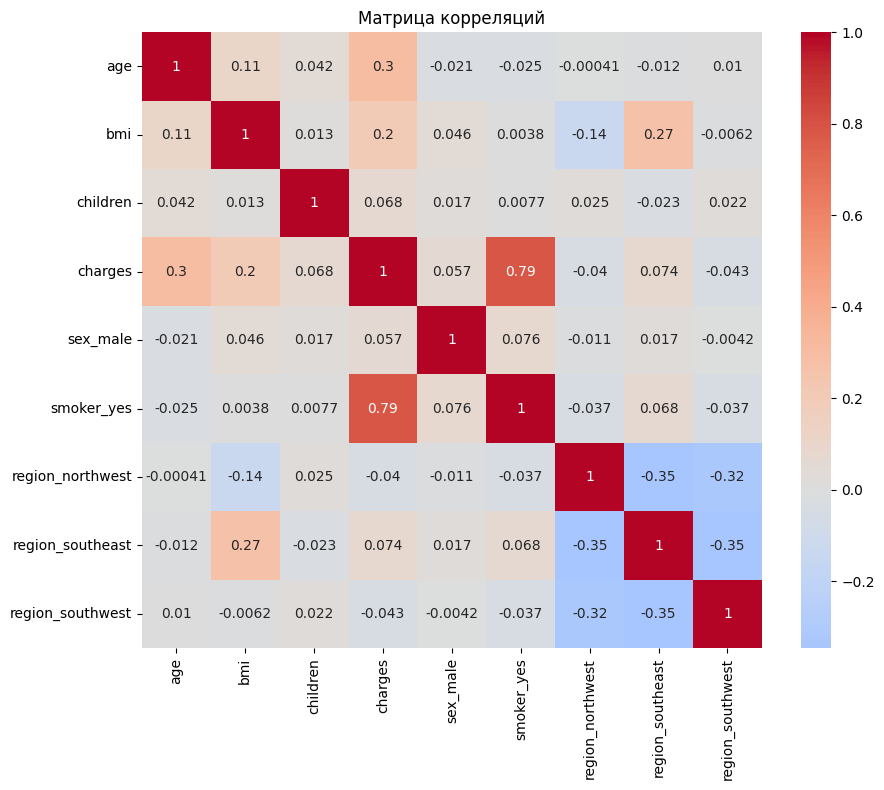

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

## 2. Многомерная линейная регрессия

In [6]:
X_df = np.asarray(df.drop('charges', axis=1))
y_df = np.asarray(df['charges'])
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

### 2.1 Построить модель линейной регрессии и подобрать параметры аналитически (реализовать самому)

$$
2X^T(Xw-y) = 0
$$

$$
X^TXw = X^Ty
$$

$$
w^* = (X^TX)^{-1}X^Ty
$$

In [7]:
class AnaliticRegression:
    def __init__(self):
        self.w = None

    def fit(self, X, y):
        X = np.column_stack([np.ones(X.shape[0]), X])
        self.w = np.linalg.inv(X.T @ X) @ (X.T @ y)
        return self

    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        return X @ self.w

### 2.2 Построить модель численно, с помощью методов градиентного спуска (реализовать самому)

$$w^{(k+1)} = w^{(k)} - \lambda \cdot \frac{\partial Q}{\partial w}|_{w=w^{(k)}}$$

In [8]:
class GradientDescent:
    def __init__(self, learning_rate=3e-4, n_iter=1000):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.w = None

    def fit(self, X, y):
        X = np.column_stack([np.ones(X.shape[0]), X])
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        for i in range(self.n_iter):
            grad = 2 * X.T @ (X @ self.w - y)
            self.w -= self.lr * grad
            
        return self

    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        return X @ self.w

## 3. Добавление регуляризации

### 3.1 Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса аналитически

$$
Q_{L_2}(w) = ||Xw - y||^2 + \alpha ||w||_2^2 \rightarrow \min_{w}
$$

$$
||a||_2 = \sqrt{\sum_{i=1}^{n} a_i^2}
$$

$$
w^* = (X^TX + \alpha I)^{-1}X^Ty
$$

$$
\frac{\partial Q_{L_2}}{\partial w} = 2 X^T (Xw - y) + 2 \alpha w
$$

In [9]:
class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.w = None

    def fit(self, X, y):
        X = np.column_stack([np.ones(X.shape[0]), X])
        n_samples, n_features = X.shape

        XtX = X.T @ X
        regularization = self.alpha * np.eye(n_features)
        self.w = np.linalg.inv(XtX + regularization) @ X.T @ y

        return self

    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        return X @ self.w

### 3.2 Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса численно

$$
Q_{L_1}(w) = ||Xw - y||^2 + \beta ||w||_1 \rightarrow \min_{w}
$$

$$
||a||_1 = \sum_{i=1}^{n} |a_i|
$$

$$
\frac{\partial Q_{L_1}}{\partial w} = 2 X^T (Xw - y) + \beta~sign(w)
$$

In [10]:
class LassoSGD:
    def __init__(self, beta=0.1, learning_rate=0.01, n_epochs=1000):
        self.beta = beta
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.w = None

    def fit(self, X, y):
        X = np.column_stack([np.ones(X.shape[0]), X])
        n_samples, n_features = X.shape
        
        self.w = np.zeros(n_features)

        for epoch in range(self.n_epochs):
            y_pred = X @ self.w
            grad_mse = 2 * X.T @ (y_pred - y) / n_samples
            grad_l1 = self.beta * np.sign(self.w)
            grad_total = grad_mse + grad_l1
            self.w -= self.learning_rate * grad_total

        return self

    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        return X @ self.w

### 3.3 Предсказание константой

In [11]:
class ConstantRegression:
    def __init__(self):
        self.mean = 0

    def fit(self, X, y):
        self.mean = y.mean()
        return self

    def predict(self, X):
        return np.full(X.shape[0], self.mean)

## 4. Оценка обобщающей способности

In [12]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f"{name}: {mse}, {rmse}")

In [13]:
models = {
    "Аналитическая регрессия": AnaliticRegression(),
    "Градиентный спуск": GradientDescent(),
    "Аналитический Ridge": RidgeRegression(),
    "LassoSGD": LassoSGD(),
    "Константа": ConstantRegression()
}

evaluate_models(models, X_train, X_test, y_train, y_test)

Аналитическая регрессия: 33596915.85136146, 5796.2846592762735
Градиентный спуск: 33596915.85136148, 5796.284659276275
Аналитический Ridge: 33599659.532941006, 5796.521330327441
LassoSGD: 33597545.748679064, 5796.338995321018
Константа: 155391443.68461317, 12465.610441715768
